In [168]:
import numpy as np
import utils
from matplotlib import pyplot as plt
from scipy import constants as const
from scipy import optimize
from pytablewriter import MarkdownTableWriter

## Rates from Xu et al. (2015)

In [2]:
class XuCH3ORate:
    'H + H2CO (+ M) <=> CH3O (+ M)'
    def __init__(self):
        self.rate = {}
        self.rate['1atm_lowT'] = {'A': 2.32e-10, 'b': -1.22, 'Ea': 1813.2}
        self.rate['1atm_highT'] = {'A': 3.10e8, 'b': -6.79, 'Ea': 5573.9}
        self.rate['100atm_lowT'] = {'A': 7.12e-14, 'b': 0.45, 'Ea': 1587.1}
        self.rate['100atm_highT'] = {'A': 3.8e21, 'b': -10.15, 'Ea': 9000.0}

    def rate_1atm(self, T):
        if T < 800:
            tmp = self.rate['1atm_lowT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        else:
            tmp = self.rate['1atm_highT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k

    def rate_100atm(self, T):
        if T < 800:
            tmp = self.rate['100atm_lowT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        else:
            tmp = self.rate['100atm_highT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k

class XuH2COHRate:
    'H + H2CO (+ M) <=> H2COH (+ M)'
    def __init__(self):
        self.rate = {}
        self.rate['1atm_lowT'] = {'A': 7e-10, 'b': -1.4, 'Ea': 2612.5}
        self.rate['1atm_highT'] = {'A': 3.14e7, 'b': -6.23, 'Ea': 7720.3}
        self.rate['100atm_lowT'] = {'A': 7.43e-21, 'b': 2.84, 'Ea': 3003.7}
        self.rate['100atm_highT'] = {'A': 6.09e15, 'b': -8.04, 'Ea': 10826.2}

    def rate_1atm(self, T):
        if T < 1000:
            tmp = self.rate['1atm_lowT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        else:
            tmp = self.rate['1atm_highT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k

    def rate_100atm(self, T):
        if T < 1000:
            tmp = self.rate['100atm_lowT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        else:
            tmp = self.rate['100atm_highT']
            k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k
        

## Fit for H + H2CO (+ M) <=> CH3O (+ M)

In [3]:
def make_data():
    T = np.append(np.linspace(200,1000,100),np.linspace(1000,2000,10))
    
    xu1 = XuCH3ORate()
    data = {}

    # 1 atm
    P = 1e6*1.01325
    k = np.array([xu1.rate_1atm(T1) for T1 in T])
    data['1atm'] = {}
    data['1atm']['T'] = T.copy()
    data['1atm']['k'] = k
    data['1atm']['P'] = P
    data['1atm']['n'] = P/(const.k*1e7*T)

    # 100 atm
    P = 100e6*1.01325
    k = np.array([xu1.rate_100atm(T1) for T1 in T])
    data['100atm'] = {}
    data['100atm']['T'] = T.copy()
    data['100atm']['k'] = k
    data['100atm']['P'] = P
    data['100atm']['n'] = P/(const.k*1e7*T)

    return data
    

In [4]:
def falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T):
    k0 = utils.arrhenius_rate(A_0, b_0, Ea_0, T)
    kinf = utils.arrhenius_rate(A_inf, b_inf, Ea_inf, T)
    k = n*k0/(1+(k0*n/kinf))
    return k

def objective(x, data):
    A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf = x
    
    klow = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, data['1atm']['n'], data['1atm']['T'])
    khigh = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, data['100atm']['n'], data['100atm']['T'])

    res_low = np.log10(klow) - np.log10(data['1atm']['k'])
    res_high = np.log10(khigh) - np.log10(data['100atm']['k'])
    res = np.append(res_low,res_high)
    return res

def main():
    data = make_data()
    init = np.array([5.13e-22, -3.0, 3360.0, 8.0e-10, 0.0, 3160.0])
    sol = optimize.root(objective,init,method='lm',args=data,options={'maxiter':1000000})
    return sol
    

In [5]:
sol = main()
print(sol.success)

True


/var/folders/sf/43vm953d201c4jw4yg22hnhc0000gn/T/ipykernel_51251/1033239290.py:13: RuntimeWarning: invalid value encountered in log10
  res_low = np.log10(klow) - np.log10(data['1atm']['k'])
/var/folders/sf/43vm953d201c4jw4yg22hnhc0000gn/T/ipykernel_51251/1033239290.py:14: RuntimeWarning: invalid value encountered in log10
  res_high = np.log10(khigh) - np.log10(data['100atm']['k'])


In [6]:
A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf = sol.x

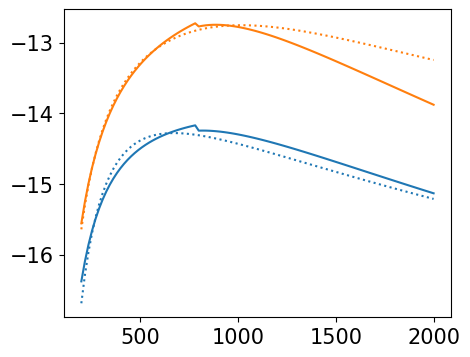

In [7]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

T = np.linspace(200,2000,100)
xu1 = XuCH3ORate()

# 1 atm case
P = 1e6*1.01325
n = P/(const.k*1e7*T)
k = np.array([xu1.rate_1atm(T1) for T1 in T])
ax.plot(T, np.log10(k),c='C0')

k_fit = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(T, np.log10(k_fit),':',c='C0')

# 100 atm case
P = 100e6*1.01325
n = P/(const.k*1e7*T)
k = np.array([xu1.rate_100atm(T1) for T1 in T])
ax.plot(T, np.log10(k),c='C1')

k_fit = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(T, np.log10(k_fit),':',c='C1')

plt.show()

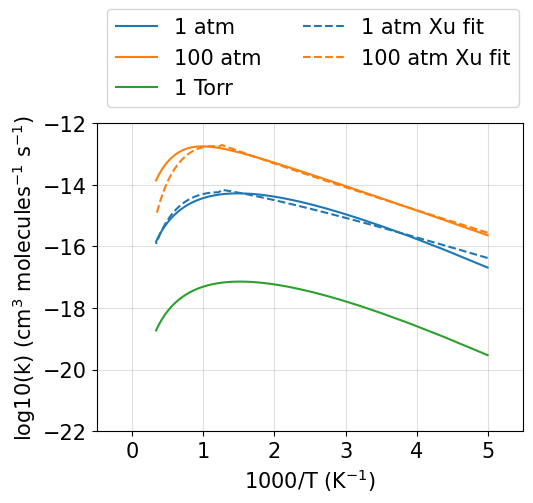

In [8]:
A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf = sol.x

T = np.linspace(200,3000,100)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5.5,4])

P = 1e6*1.01325
n = P/(const.k*1e7*T)
k = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(1000/T,np.log10(k),label='1 atm',c='C0')

P = 100e6*1.01325
n = P/(const.k*1e7*T)
k = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(1000/T,np.log10(k),label='100 atm',c='C1')

P = 0.00133322e6
n = P/(const.k*1e7*T)
k = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(1000/T,np.log10(k),label='1 Torr',c='C2')

k = np.array([xu1.rate_1atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),ls='--',c='C0',label='1 atm Xu fit')

k = np.array([xu1.rate_100atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),ls='--',c='C1',label='100 atm Xu fit')

ax.set_xlim(-0.5,5.5)
ax.set_ylim(-22,-12)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (cm$^{3}$ molecules$^{-1}$ s$^{-1}$)')
ax.set_xlabel('1000/T (K$^{-1}$)')
ax.legend(ncol=2,bbox_to_anchor=(0, 1.02), loc='lower left')

plt.savefig('figures/Figure10_Xu2015_fit_H+H2CO+M=CH3O+M.pdf',bbox_inches='tight')
plt.show()

In [16]:
print('%.2e'%A_0)
print('%.3f'%b_0)
print('%.1f'%Ea_0)


print('%.2e'%A_inf)
print('%.3f'%b_inf)
print('%.1f'%Ea_inf)
# b_0, Ea_0, A_inf, b_inf, Ea_inf

1.13e-20
-3.973
3281.8
8.96e-12
-0.205
1877.0


## Fit for H + H2CO (+ M) <=> H2COH (+ M)

In [17]:
def make_data():
    
    xu2 = XuH2COHRate()
    data = {}

    T = np.linspace(200,800,100)

    # 1 atm
    P = 1e6*1.01325
    k = np.array([xu2.rate_1atm(T1) for T1 in T])
    data['1atm'] = {}
    data['1atm']['T'] = T.copy()
    data['1atm']['k'] = k
    data['1atm']['P'] = P
    data['1atm']['n'] = P/(const.k*1e7*T)

    T = np.linspace(800,2000,100)

    # 100 atm
    P = 100e6*1.01325
    k = np.array([xu2.rate_100atm(T1) for T1 in T])
    data['100atm'] = {}
    data['100atm']['T'] = T.copy()
    data['100atm']['k'] = k
    data['100atm']['P'] = P
    data['100atm']['n'] = P/(const.k*1e7*T)

    return data

In [18]:
def falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T):
    k0 = utils.arrhenius_rate(A_0, b_0, Ea_0, T)
    kinf = utils.arrhenius_rate(A_inf, b_inf, Ea_inf, T)
    k = n*k0/(1+(k0*n/kinf))
    return k

def objective(x, data):
    A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf = x
    
    klow = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, data['1atm']['n'], data['1atm']['T'])
    khigh = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, data['100atm']['n'], data['100atm']['T'])

    res_low = np.log10(klow) - np.log10(data['1atm']['k'])
    res_high = np.log10(khigh) - np.log10(data['100atm']['k'])
    res = np.append(res_low,res_high)
    return res

def main():
    data = make_data()
    init = np.array([3.0e-33, 0.0, 600, 3.0e-14,0.0,600])
    sol = optimize.root(objective,init,method='lm',args=data,options={'maxiter':1000000})
    return sol

In [19]:
sol = main()
print(sol.success)

True


/var/folders/sf/43vm953d201c4jw4yg22hnhc0000gn/T/ipykernel_51251/3682141480.py:13: RuntimeWarning: invalid value encountered in log10
  res_low = np.log10(klow) - np.log10(data['1atm']['k'])
/var/folders/sf/43vm953d201c4jw4yg22hnhc0000gn/T/ipykernel_51251/3682141480.py:14: RuntimeWarning: invalid value encountered in log10
  res_high = np.log10(khigh) - np.log10(data['100atm']['k'])


In [20]:
A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf = sol.x

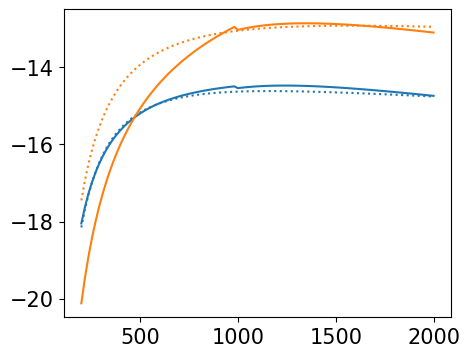

In [21]:
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5,4])

T = np.linspace(200,2000,100)
xu2 = XuH2COHRate()

# 1 atm case
P = 1e6*1.01325
n = P/(const.k*1e7*T)
k = np.array([xu2.rate_1atm(T1) for T1 in T])
ax.plot(T, np.log10(k),c='C0')

k_fit = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(T, np.log10(k_fit),':',c='C0')

# 100 atm case
P = 100e6*1.01325
n = P/(const.k*1e7*T)
k = np.array([xu2.rate_100atm(T1) for T1 in T])
ax.plot(T, np.log10(k),c='C1')

k_fit = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(T, np.log10(k_fit),':',c='C1')

plt.show()

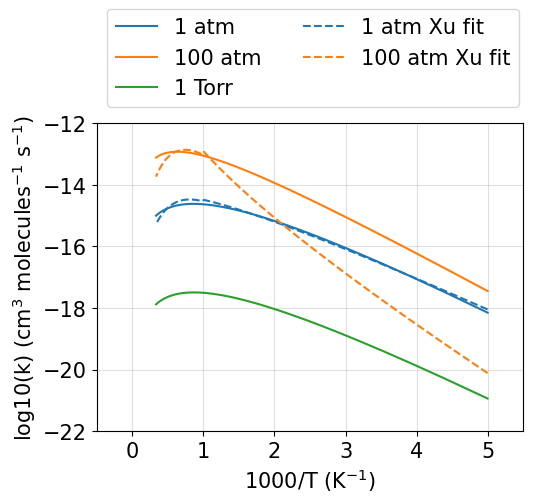

In [22]:
A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf = sol.x

T = np.linspace(200,3000,100)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1,figsize=[5.5,4])

P = 1e6*1.01325
n = P/(const.k*1e7*T)
k = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(1000/T,np.log10(k),label='1 atm',c='C0')

P = 100e6*1.01325
n = P/(const.k*1e7*T)
k = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(1000/T,np.log10(k),label='100 atm',c='C1')

P = 0.00133322e6
n = P/(const.k*1e7*T)
k = falloff_rate(A_0, b_0, Ea_0, A_inf, b_inf, Ea_inf, n, T)
ax.plot(1000/T,np.log10(k),label='1 Torr',c='C2')

k = np.array([xu2.rate_1atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),ls='--',c='C0',label='1 atm Xu fit')

k = np.array([xu2.rate_100atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),ls='--',c='C1',label='100 atm Xu fit')

ax.set_xlim(-0.5,5.5)
ax.set_ylim(-22,-12)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (cm$^{3}$ molecules$^{-1}$ s$^{-1}$)')
ax.set_xlabel('1000/T (K$^{-1}$)')
ax.legend(ncol=2,bbox_to_anchor=(0, 1.02), loc='lower left')

# plt.savefig('figures/Figure9_Xu2015_fit_H+H2CO+M=H2COH+M.pdf',bbox_inches='tight')
plt.show()

In [24]:
print('%.2e'%A_0)
print('%.3f'%b_0)
print('%.1f'%Ea_0)

print('%.2e'%A_inf)
print('%.3f'%b_inf)
print('%.1f'%Ea_inf)

4.98e-28
-1.625
3032.0
5.80e-09
-1.095
3074.9


## Reverse of H + H2CO (+ M) <=> CH3O (+ M)

In [84]:
class XuCH3OReverseRate:
    'CH3O (+ M) <=> H + H2CO (+ M)'
    def __init__(self):
        self.rate = {}
        self.rate['1atm'] = {'A': 3.17e24, 'b': -4.25, 'Ea': 13104.9}
        self.rate['100atm'] = {'A': 8.5e28, 'b': -5.09, 'Ea': 14384.5}

    def rate_1atm(self, T):
        tmp = self.rate['1atm']
        k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k

    def rate_100atm(self, T):
        tmp = self.rate['100atm']
        k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k

In [85]:
r = utils.ReactionExplorer('thermodata121_test.yaml')
xu = XuCH3OReverseRate()

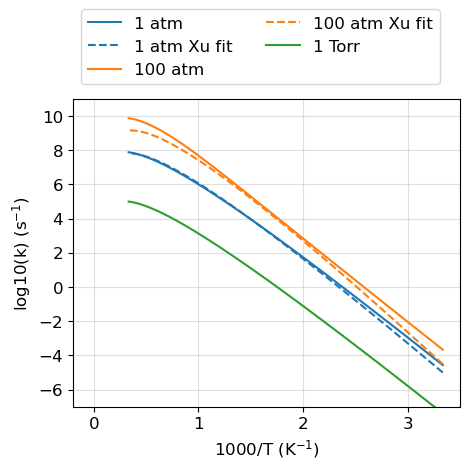

In [86]:
T = np.linspace(300,3000,100)

plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,1,figsize=[5,4])

P = 1*1.01325
k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r.evaluate_rates(T1, P)
    k1[i] = tmp[0]['k_r']
ax.plot(1000/T, np.log10(k1),label='1 atm',c='C0')

k = np.array([xu.rate_1atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),label='1 atm Xu fit',c='C0',ls='--')

P = 100*1.01325
k2 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r.evaluate_rates(T1, P)
    k2[i] = tmp[0]['k_r']
ax.plot(1000/T, np.log10(k2),label='100 atm',c='C1',ls='-')

k = np.array([xu.rate_100atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),label='100 atm Xu fit',c='C1',ls='--')

P = 0.00133322
k2 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r.evaluate_rates(T1, P)
    k2[i] = tmp[0]['k_r']
ax.plot(1000/T, np.log10(k2),label='1 Torr',c='C2',ls='-')

ax.set_xlim(-0.2,3.5)
ax.set_ylim(-7,11)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (s$^{-1}$)')
ax.set_xlabel('1000/T (K$^{-1}$)')
ax.legend(ncol=2,bbox_to_anchor=(0, 1.02), loc='lower left')

# plt.savefig('figures/Figure12_Xu2015_fit_H+H2CO+M=CH3O+M_reversed_thermodata120.pdf',bbox_inches='tight')
plt.show()

## Reverse of H2COH + M <=> H + H2CO + M

In [87]:
class XuH2COHReverseRate:
    'H2COH (+ M) <=> H + H2CO (+ M)'
    def __init__(self):
        self.rate = {}
        self.rate['1atm'] = {'A': 4.52e34, 'b': -7.11, 'Ea': 22176.3}
        self.rate['100atm'] = {'A': 3.39e32, 'b': -5.88, 'Ea': 23371.8}

    def rate_1atm(self, T):
        tmp = self.rate['1atm']
        k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k

    def rate_100atm(self, T):
        tmp = self.rate['100atm']
        k = utils.arrhenius_rate(tmp['A'],tmp['b'],tmp['Ea'], T)
        return k

In [88]:
r = utils.ReactionExplorer('thermodata121_test.yaml')
xu = XuH2COHReverseRate()

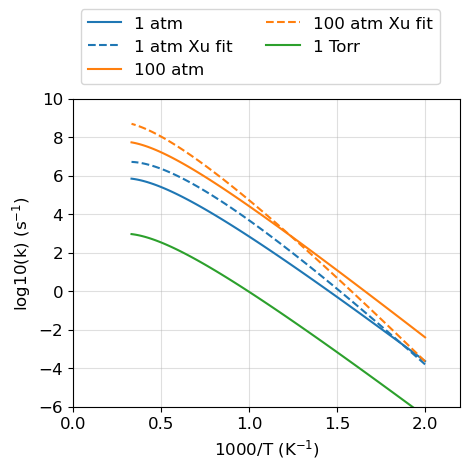

In [89]:
T = np.linspace(500,3000,100)

plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,1,figsize=[5,4])

P = 1*1.01325
k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r.evaluate_rates(T1, P)
    k1[i] = tmp[3]['k_r']
ax.plot(1000/T, np.log10(k1),label='1 atm',c='C0')

k = np.array([xu.rate_1atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),label='1 atm Xu fit',c='C0',ls='--')

P = 100*1.01325
k2 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r.evaluate_rates(T1, P)
    k2[i] = tmp[3]['k_r']
ax.plot(1000/T, np.log10(k2),label='100 atm',c='C1',ls='-')

k = np.array([xu.rate_100atm(T1) for T1 in T])
ax.plot(1000/T, np.log10(k),label='100 atm Xu fit',c='C1',ls='--')

P = 0.00133322
k2 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r.evaluate_rates(T1, P)
    k2[i] = tmp[3]['k_r']
ax.plot(1000/T, np.log10(k2),label='1 Torr',c='C2',ls='-')

ax.set_xlim(0,2.2)
ax.set_ylim(-6,10)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (s$^{-1}$)')
ax.set_xlabel('1000/T (K$^{-1}$)')
ax.legend(ncol=2,bbox_to_anchor=(0, 1.02), loc='lower left')

# plt.savefig('figures/Figure11_Xu2015_fit_H+H2CO+M=H2COH+M_reversed_thermodata120.pdf',bbox_inches='tight')
plt.show()

# Comparison between models

In [103]:
r1 = utils.ReactionExplorer('thermodata121_test.yaml')
r2 = utils.ReactionExplorer('shamithermo_test.yaml')

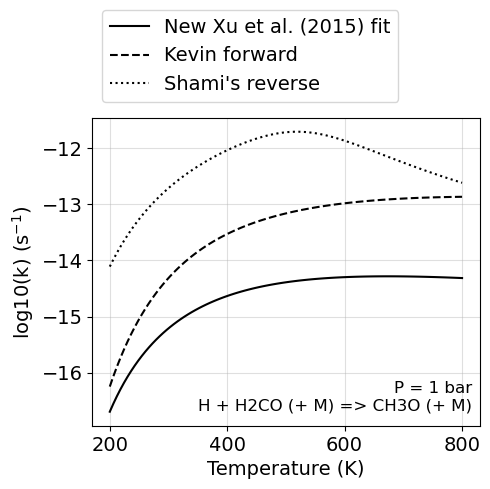

In [129]:
T = np.linspace(200,800,100)

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,1,figsize=[5,4])

P = 1.0
k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r1.evaluate_rates(T1, P)
    k1[i] = tmp[0]['k_f']
ax.plot(T, np.log10(k1),label='New Xu et al. (2015) fit',c='k',ls='-')

k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r1.evaluate_rates(T1, P)
    k1[i] = tmp[1]['k_f']
ax.plot(T, np.log10(k1),label='Kevin forward',c='k',ls='--')

k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r2.evaluate_rates(T1, P)
    k1[i] = tmp[2]['k_r']
ax.plot(T, np.log10(k1),label="Shami's reverse",c='k',ls=':')

# ax.set_xlim(-.2,5.2)
# ax.set_ylim(-22,-12)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (s$^{-1}$)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')

ax.text(0.98, .04, 'P = 1 bar\nH + H2CO (+ M) => CH3O (+ M)', \
        size = 12,ha='right', va='bottom',transform=ax.transAxes)

# plt.savefig('figures/comparison_H+H2CO+M=CH3O+M.pdf',bbox_inches='tight')
plt.show()

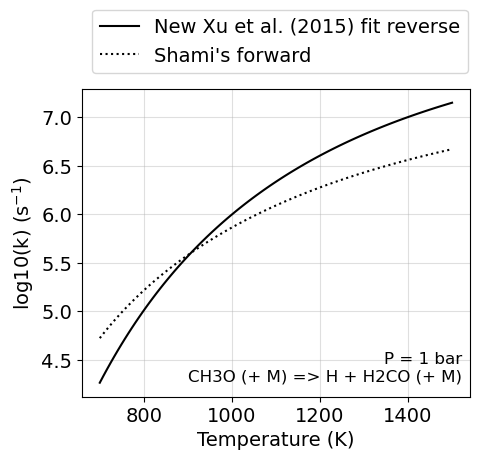

In [151]:
T = np.linspace(700,1500,100)

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,1,figsize=[5,4])

P = 1.0
k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r1.evaluate_rates(T1, P)
    k1[i] = tmp[0]['k_r']
ax.plot(T, np.log10(k1),label='New Xu et al. (2015) fit reverse',c='k',ls='-')

k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r2.evaluate_rates(T1, P)
    k1[i] = tmp[2]['k_f']
ax.plot(T, np.log10(k1),label="Shami's forward",c='k',ls=':')

# ax.set_xlim(-.2,5.2)
# ax.set_ylim(-22,-12)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (s$^{-1}$)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')

ax.text(0.98, .04, 'P = 1 bar\nCH3O (+ M) => H + H2CO (+ M)', \
        size = 12,ha='right', va='bottom',transform=ax.transAxes)

# plt.savefig('figures/comparison_CH3O+M=H+H2CO+M.pdf',bbox_inches='tight')
plt.show()

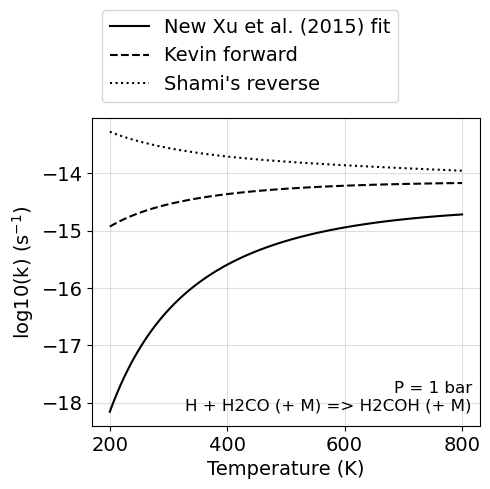

In [133]:
T = np.linspace(200,800,100)

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,1,figsize=[5,4])

P = 1.0
k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r1.evaluate_rates(T1, P)
    k1[i] = tmp[3]['k_f']
ax.plot(T, np.log10(k1),label='New Xu et al. (2015) fit',c='k',ls='-')

k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r1.evaluate_rates(T1, P)
    k1[i] = tmp[4]['k_f']
ax.plot(T, np.log10(k1),label='Kevin forward',c='k',ls='--')

k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r2.evaluate_rates(T1, P)
    k1[i] = tmp[5]['k_r']
ax.plot(T, np.log10(k1),label="Shami's reverse",c='k',ls=':')

# ax.set_xlim(-.2,5.2)
# ax.set_ylim(-22,-12)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (s$^{-1}$)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')

ax.text(0.98, .04, 'P = 1 bar\nH + H2CO (+ M) => H2COH (+ M)', \
        size = 12,ha='right', va='bottom',transform=ax.transAxes)

# plt.savefig('figures/comparison_H+H2CO+M=H2COH+M.pdf',bbox_inches='tight')
plt.show()

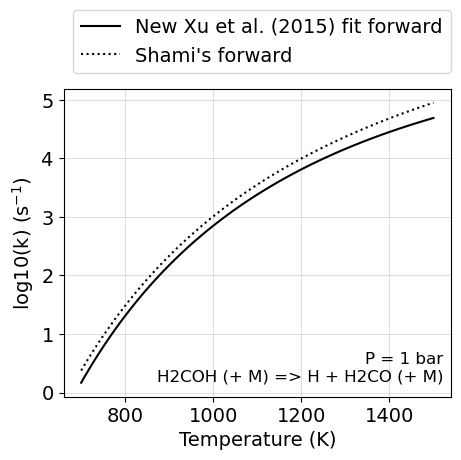

In [149]:
T = np.linspace(700,1500,100)

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,1,figsize=[5,4])

P = 1.0
k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r1.evaluate_rates(T1, P)
    k1[i] = tmp[3]['k_r']
ax.plot(T, np.log10(k1),label='New Xu et al. (2015) fit forward',c='k',ls='-')

k1 = np.empty(T.shape[0])
for i,T1 in enumerate(T):
    tmp  = r2.evaluate_rates(T1, P)
    k1[i] = tmp[5]['k_f']
ax.plot(T, np.log10(k1),label="Shami's forward",c='k',ls=':')

# ax.set_xlim(-.2,5.2)
# ax.set_ylim(-22,-12)
ax.grid(alpha=0.4)
ax.set_ylabel('log10(k) (s$^{-1}$)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1,bbox_to_anchor=(0, 1.02), loc='lower left')

ax.text(0.98, .04, 'P = 1 bar\nH2COH (+ M) => H + H2CO (+ M)', \
        size = 12,ha='right', va='bottom',transform=ax.transAxes)

# plt.savefig('figures/comparison_H2COH+M=H+H2CO+M.pdf',bbox_inches='tight')
plt.show()

In [169]:
r1 = utils.ReactionExplorer('thermodata121_test.yaml')
r2 = utils.ReactionExplorer('shamithermo_test.yaml')

In [171]:
P,T = 1,298
species = ['H','H2CO','CH3O','H2COH']

labels = ['species','thermodata121 enthalpy (kJ/mol)','Shami enthalpy (kJ/mol)','thermodata121 entropy (J/mol/K)','Shami entropy (J/mol/K)']
value_matrix = []
for sp in species:
    value = []
    value.append(sp)
    tmp = '%.1f'%(r1.enthalpy(sp,T)/1e3)
    value.append(tmp)
    tmp = '%.1f'%(r2.enthalpy(sp,T)/1e3)
    value.append(tmp)
    tmp = '%.1f'%(r1.entropy(sp,T))
    value.append(tmp)
    tmp = '%.1f'%(r2.entropy(sp,T))
    value.append(tmp)
    value_matrix.append(value)
    
    
writer = MarkdownTableWriter(
    table_name="T = 298 K thermodynamics",
    headers=labels,
    value_matrix=value_matrix,
)
writer.write_table()

# T = 298 K thermodynamics
|species|thermodata121 enthalpy (kJ/mol)|Shami enthalpy (kJ/mol)|thermodata121 entropy (J/mol/K)|Shami entropy (J/mol/K)|
|-------|------------------------------:|----------------------:|------------------------------:|----------------------:|
|H      |                          218.0|                  218.0|                          114.7|                  114.7|
|H2CO   |                         -108.9|                 -108.6|                          218.9|                  218.7|
|CH3O   |                           29.0|                   13.0|                          234.0|                  236.0|
|H2COH  |                           -9.0|                  -17.8|                          244.0|                  244.1|
